# Airbnb Data for Analysis

In [1]:
import pandas as pd
import numpy as np
import pylab
import math
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy import stats

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

## The Data
This data set was pulled from kaggle.  It is titled the 'Seattle Airbnb' on kaggle.  It happend to be the same zip codes as the KC county data set.  

In [6]:
df1 = pd.read_csv('data/listings.csv')

In [7]:
df1.shape

(3818, 20)

### Data Cleaning
Standard getting rid of null values.   The unique part about cleaning this data set is that it originally came with over 150 columns off of the kaggle website.  Most of those columns were also useless for traditional data analysis with paragraph long entries such as reviews.  I chopped off most of the excess columns when I saved it to an excel file on the local drive.  

In [8]:
df1.dropna(inplace = True)

In [9]:
df1.head()

,id,host_is_superhost,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,weekly_price,monthly_price,cleaning_fee,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1,953595,t,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,"$1,000.00","$3,000.00",$40.00,1,96.0,10.0,10.0,10.0,10.0,10.0,10.0
9,2493658,t,98119,Apartment,Entire home/apt,4,1.0,1.0,1.0,"$1,000.00","$3,000.00",$40.00,1,97.0,10.0,10.0,10.0,10.0,10.0,9.0
11,4454295,f,98119,House,Entire home/apt,2,1.0,1.0,1.0,$800.00,"$2,000.00",$150.00,1,97.0,10.0,10.0,9.0,10.0,10.0,9.0
12,3883392,t,98119,Apartment,Entire home/apt,4,1.0,2.0,3.0,"$1,575.00","$5,800.00",$95.00,1,98.0,10.0,10.0,10.0,10.0,10.0,10.0
21,4125779,f,98119,House,Private room,3,1.5,1.0,2.0,$568.00,"$2,029.00",$15.00,1,84.0,9.0,9.0,9.0,9.0,10.0,8.0


In [10]:
display(df1.isnull().any())
df1.shape

id                             False
host_is_superhost              False
zipcode                        False
property_type                  False
room_type                      False
accommodates                   False
bathrooms                      False
bedrooms                       False
beds                           False
weekly_price                   False
monthly_price                  False
cleaning_fee                   False
guests_included                False
review_scores_rating           False
review_scores_accuracy         False
review_scores_cleanliness      False
review_scores_checkin          False
review_scores_communication    False
review_scores_location         False
review_scores_value            False
dtype: bool

(1032, 20)

After getting rid of all of the null values I am filtering the data down to the columns I think will be applicable along with the KC data set.  

In [11]:
df_abnb = df1.filter(['zipcode', 'property_type', 'room_type', 'bathrooms', 'bedrooms', 'monthly_price', 'review_scores_rating'], axis=1)

In [12]:
#I am doing a df.describe to discover what pandas thinks is continuous
df_abnb.describe()

,bathrooms,bedrooms,review_scores_rating
count,1032.000000,1032.000000,1032.00000
mean,1.228198,1.298450,94.05814
std,0.549675,0.844953,7.32656
min,0.500000,0.000000,20.00000
25%,1.000000,1.000000,92.00000
50%,1.000000,1.000000,96.00000
75%,1.000000,2.000000,99.00000
max,4.500000,6.000000,100.00000


In [13]:
#Because of the extra characters like dollar sighns and commas I need to strip these numbers to get just plain integer values.

def column_conversion(df, col):
    df[col] = df[col].str.replace("$","").str.replace(",","").str.replace(".","").astype('int')
    return df

In [14]:
column_to_convert = ['monthly_price']

for col in column_to_convert:
    df_abnb = column_conversion(df_abnb, col)

In [15]:
df_abnb['monthly_price'] = df_abnb['monthly_price'].div(100).round(2)

In [16]:
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0
21,98119,House,Private room,1.5,1.0,2029.0,84.0


### Exploring the Data
Taking a look at deeper at the categorical variables.  I first looked at some boxplot data associated with type of home and how much it rents for a month.  I was surprised to find that, excluding outliers, townhomes and condominiums tend to rent for the most.  After that I created new columns that transform the categorical columns into numeric columns making the data set easier to put into a regression model.

In [17]:
#Looking at all the unique types of categories for my two categorical columns

print(df_abnb['room_type'].unique())

['Entire home/apt' 'Private room' 'Shared room']


In [18]:
print(df_abnb['property_type'].unique())

['Apartment' 'House' 'Condominium' 'Bungalow' 'Townhouse' 'Other' 'Cabin'
 'Loft' 'Bed & Breakfast' 'Chalet' 'Camper/RV']


In [19]:
sns.set(rc={'figure.figsize':(11,8)}, font_scale=1.5, style='whitegrid')

[Text(0, 0, 'Apartment'),
 Text(1, 0, 'House'),
 Text(2, 0, 'Condominium'),
 Text(3, 0, 'Bungalow'),
 Text(4, 0, 'Townhouse'),
 Text(5, 0, 'Other'),
 Text(6, 0, 'Cabin'),
 Text(7, 0, 'Loft'),
 Text(8, 0, 'Bed & Breakfast'),
 Text(9, 0, 'Chalet'),
 Text(10, 0, 'Camper/RV')]

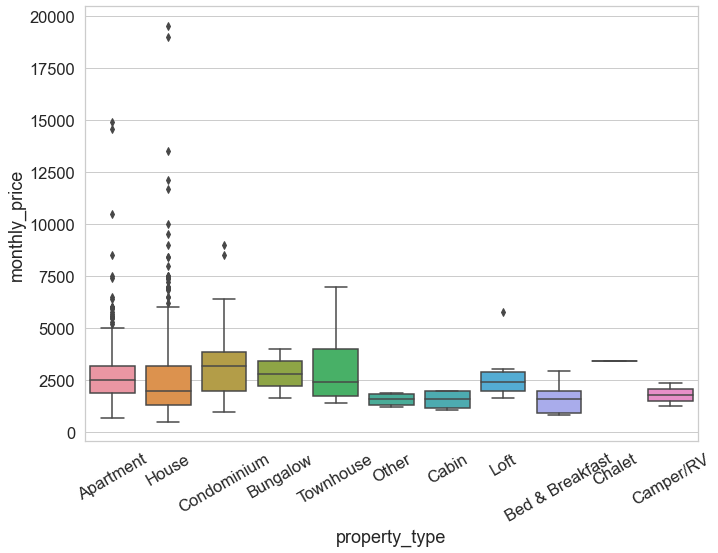

In [20]:
ax = sns.boxplot(x="property_type", y="monthly_price", data=df_abnb)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [21]:
#Below is all of the code for how I transformed the columns into numeric values.
df_abnb['property_type'] = df_abnb['property_type'].astype('category')
df_abnb.dtypes

zipcode                   object
property_type           category
room_type                 object
bathrooms                float64
bedrooms                 float64
monthly_price            float64
review_scores_rating     float64
dtype: object

In [22]:
df_abnb['property_type_cat'] = df_abnb['property_type'].cat.codes
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0,0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0,0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0,7
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0,0
21,98119,House,Private room,1.5,1.0,2029.0,84.0,7


In [23]:
df_abnb['room_type'] = df_abnb['room_type'].astype('category')
df_abnb.dtypes

zipcode                   object
property_type           category
room_type               category
bathrooms                float64
bedrooms                 float64
monthly_price            float64
review_scores_rating     float64
property_type_cat           int8
dtype: object

In [24]:
df_abnb['room_type_cat'] = df_abnb['room_type'].cat.codes
df_abnb.head()

,zipcode,property_type,room_type,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
1,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,96.0,0,0
9,98119,Apartment,Entire home/apt,1.0,1.0,3000.0,97.0,0,0
11,98119,House,Entire home/apt,1.0,1.0,2000.0,97.0,7,0
12,98119,Apartment,Entire home/apt,1.0,2.0,5800.0,98.0,0,0
21,98119,House,Private room,1.5,1.0,2029.0,84.0,7,1


In [25]:
df_abnb = df_abnb[['zipcode', 'bathrooms', 'bedrooms', 'monthly_price', 'review_scores_rating', 'property_type_cat', 'room_type_cat']]

In [26]:
df_abnb.head()

,zipcode,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
1,98119,1.0,1.0,3000.0,96.0,0,0
9,98119,1.0,1.0,3000.0,97.0,0,0
11,98119,1.0,1.0,2000.0,97.0,7,0
12,98119,1.0,2.0,5800.0,98.0,0,0
21,98119,1.5,1.0,2029.0,84.0,7,1


### Getting rid of outliers
When I initially tried to get rid of outliers using a z score it was much too agressive of a technique.  I ended up using an interquartile range technique which had its drawbacks as well.  I could only do one column so I chose monthly price because I felt like it had the most extreme outliers.

In [27]:
df_abnb.describe()

,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
count,1032.000000,1032.000000,1032.000000,1032.00000,1032.000000,1032.000000
mean,1.228198,1.298450,2708.527132,94.05814,3.795543,0.311047
std,0.549675,0.844953,1791.401138,7.32656,3.564272,0.524061
min,0.500000,0.000000,520.000000,20.00000,0.000000,0.000000
25%,1.000000,1.000000,1650.000000,92.00000,0.000000,0.000000
50%,1.000000,1.000000,2312.500000,96.00000,7.000000,0.000000
75%,1.000000,2.000000,3200.000000,99.00000,7.000000,1.000000
max,4.500000,6.000000,19500.000000,100.00000,10.000000,2.000000


In [28]:
min_threshold, max_threshold = df_abnb.monthly_price.quantile([0.25, 0.75])
min_threshold, max_threshold

(1650.0, 3200.0)

In [29]:
df_1 = df_abnb[(df_abnb.monthly_price < max_threshold) & (df_abnb.monthly_price > min_threshold)]

In [30]:
df_1.shape

(492, 7)

In [31]:
#The only other thing that looked like it might it cause problems was the review scores rating 
#column so I got rid of anyhing below the .25 quartile range.

In [32]:
df_1 = df_1[df_1['review_scores_rating'] > 92]

In [33]:
df_1.shape

(366, 7)

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'monthly_price'}>,
        <AxesSubplot:title={'center':'review_scores_rating'}>],
       [<AxesSubplot:title={'center':'property_type_cat'}>,
        <AxesSubplot:title={'center':'room_type_cat'}>]], dtype=object)

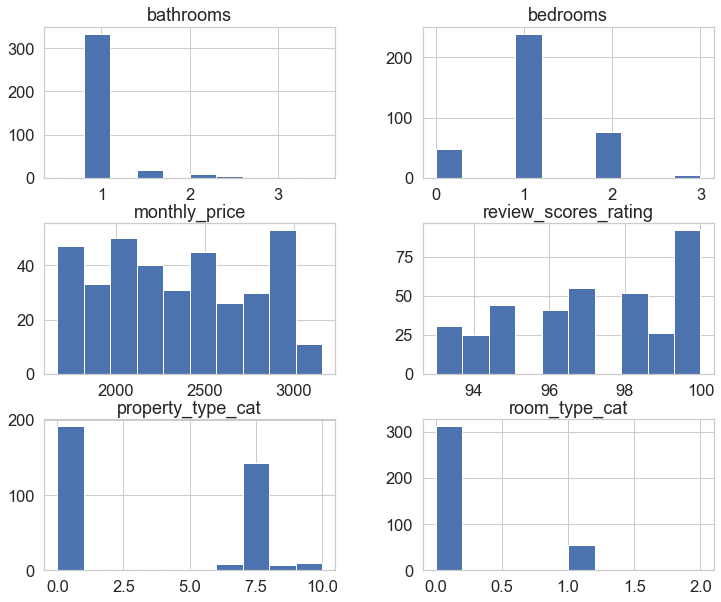

In [34]:
#looking at the distribution of each column.

df_1.hist(figsize = (12,10))

In [35]:
df_abnb['zipcode'] = df_abnb['zipcode'].astype('int')
df_abnb.dtypes

zipcode                   int32
bathrooms               float64
bedrooms                float64
monthly_price           float64
review_scores_rating    float64
property_type_cat          int8
room_type_cat              int8
dtype: object

In [36]:
#looking at the correlation between all of the columns.

df_abnb.corr()

,zipcode,bathrooms,bedrooms,monthly_price,review_scores_rating,property_type_cat,room_type_cat
zipcode,1.000000,0.091660,0.079374,-0.041459,0.050569,0.126911,0.020218
bathrooms,0.091660,1.000000,0.618600,0.520524,0.035599,0.245875,-0.127112
bedrooms,0.079374,0.618600,1.000000,0.584791,0.026180,0.256996,-0.209847
monthly_price,-0.041459,0.520524,0.584791,1.000000,0.074633,-0.032328,-0.431006
review_scores_rating,0.050569,0.035599,0.026180,0.074633,1.000000,0.073849,-0.023408
property_type_cat,0.126911,0.245875,0.256996,-0.032328,0.073849,1.000000,0.354985
room_type_cat,0.020218,-0.127112,-0.209847,-0.431006,-0.023408,0.354985,1.000000


<AxesSubplot:>

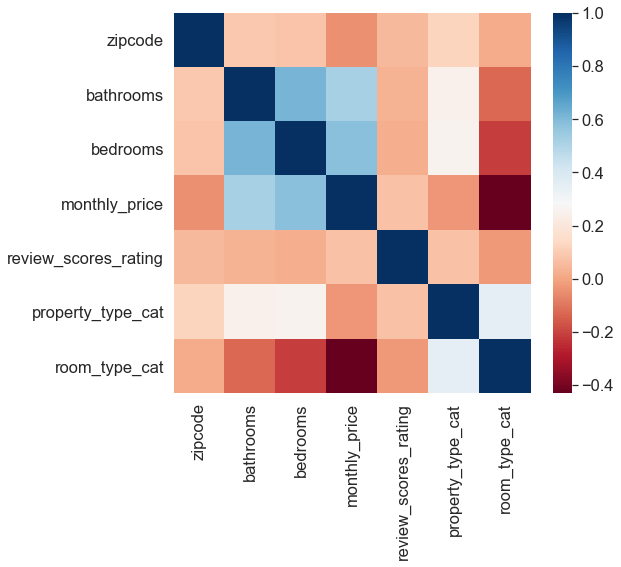

In [37]:
#Looking at the correlation between different columns to check for multicollinearity.

plt.figure(figsize = (8,7))
sns.heatmap(df_abnb.corr(), cmap = 'RdBu')